# Dependencies

In [17]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
import importlib
import logging
import os
import pickle
from glob import glob

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

try:
    os.chdir('/home/users/alexno/narcolepsy-detector')
except:
    pass

importlib.reload(logging)
logging.basicConfig(format='%(asctime)s | %(levelname)s | %(message)s', level=logging.DEBUG, datefmt='%I:%M:%S')

# Data preparation

In [20]:
data_dir = './data/massc/avg_kw21/'
files = glob(os.path.join(data_dir, '**', '*.pkl'))
curr_file = files[111]
with open(curr_file, 'rb') as pkl:
    print(curr_file)
    data = pickle.load(pkl)
print(data.keys())
data['predicted'].shape

./data/massc/avg_kw21/ihc/preds_20588FFnotte.pkl
dict_keys(['true', 'true_label', 'predicted', 'predicted_label', 'stable_sleep', 'logits', 'seq_nr', 'yhat_3s', 'yhat_5s', 'yhat_10s', 'yhat_15s'])


(920, 5)

# Plotting

## Hypnodensity

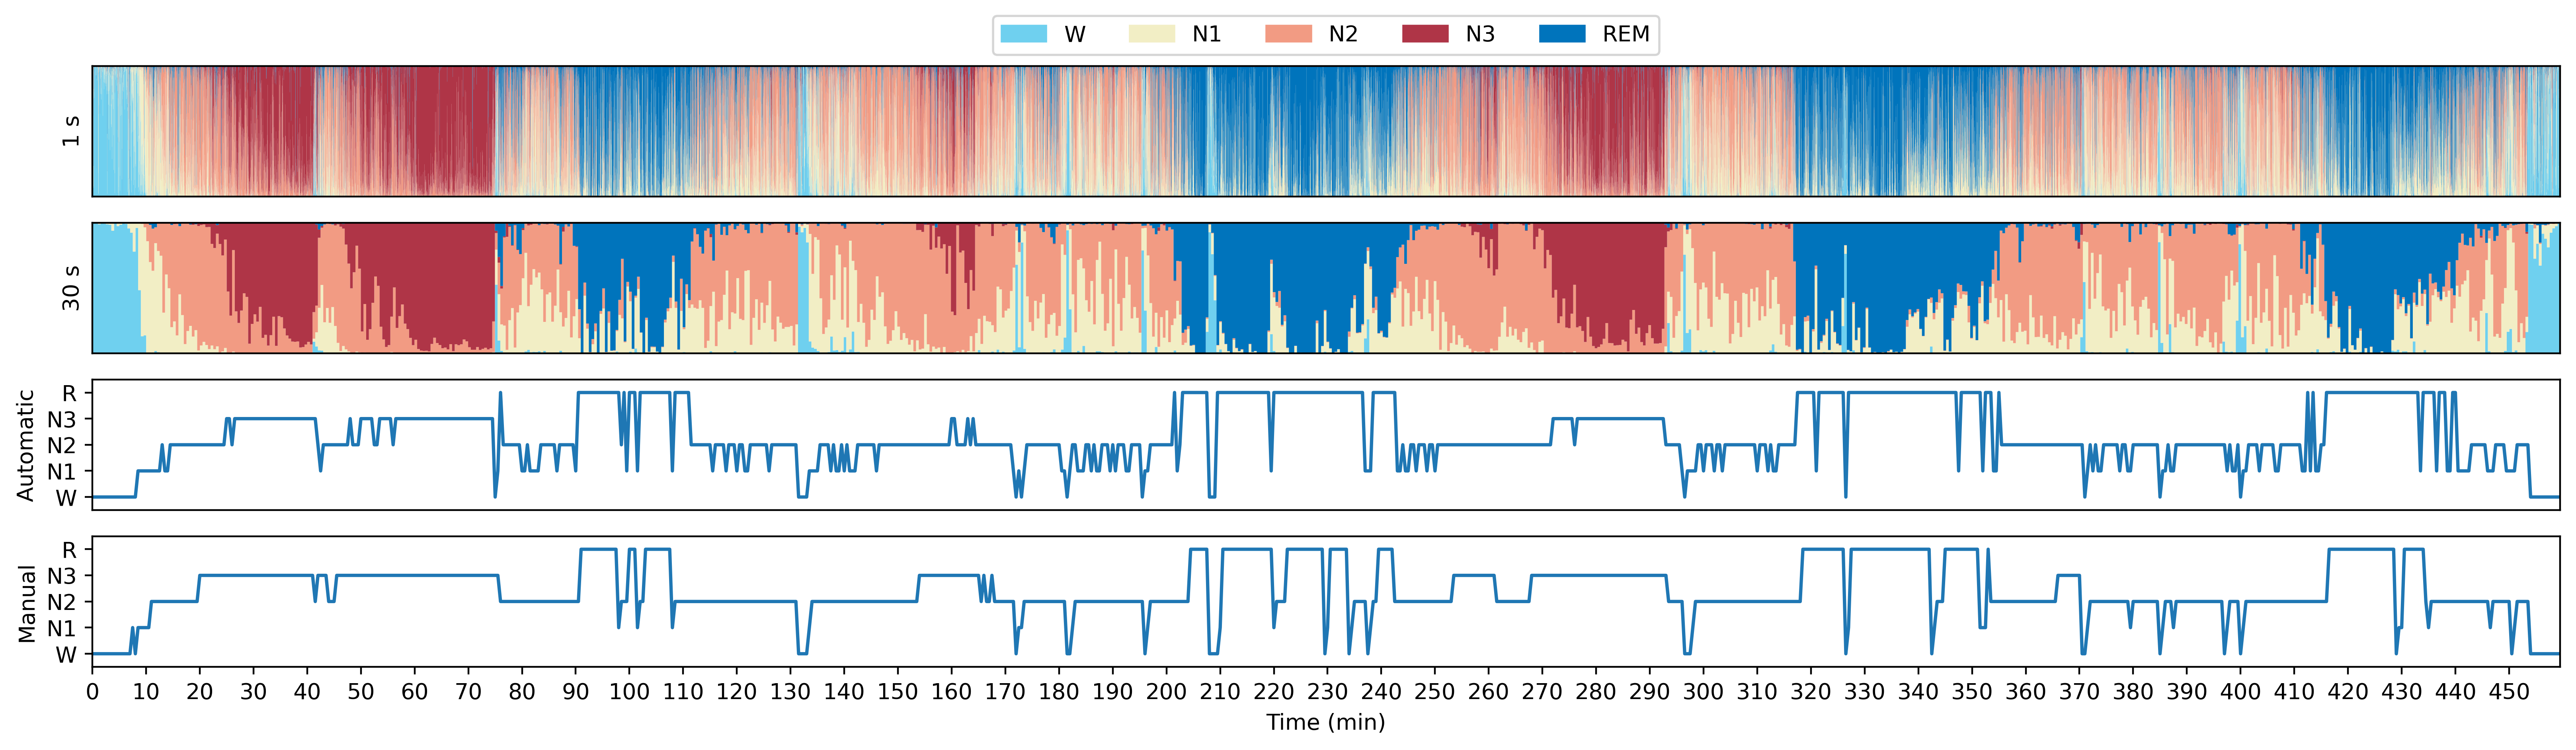

In [21]:
plot_hypnodensity(data['logits'], data['predicted'], data['true'])

## Plot confidence (largest probability value)

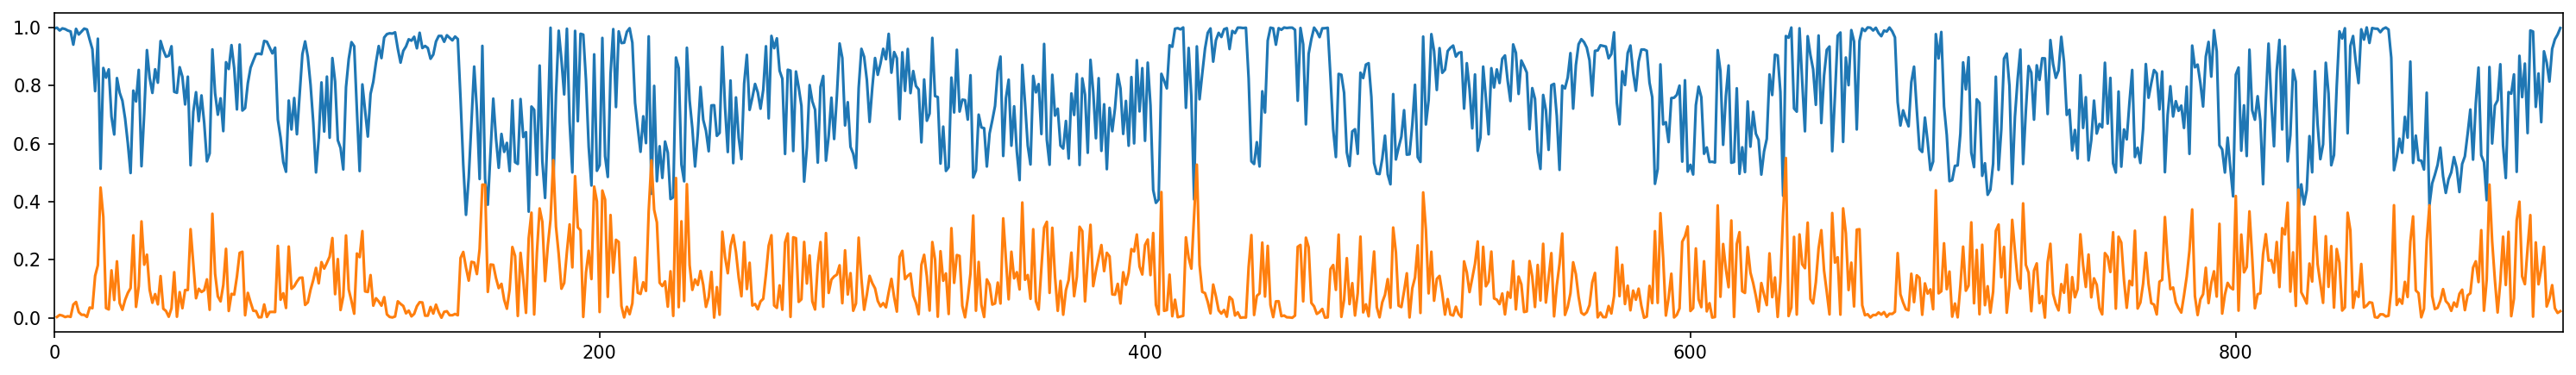

In [104]:
x = data['predicted']
plt.figure(figsize=(20, 3), dpi=150)
plt.plot(range(x.shape[0]), x.max(axis=1))
plt.plot(range(1, x.shape[0]), np.abs(np.diff(x.max(axis=1))))
plt.xlim(0, x.shape[0])
plt.tight_layout()

<AxesSubplot:ylabel='Density'>

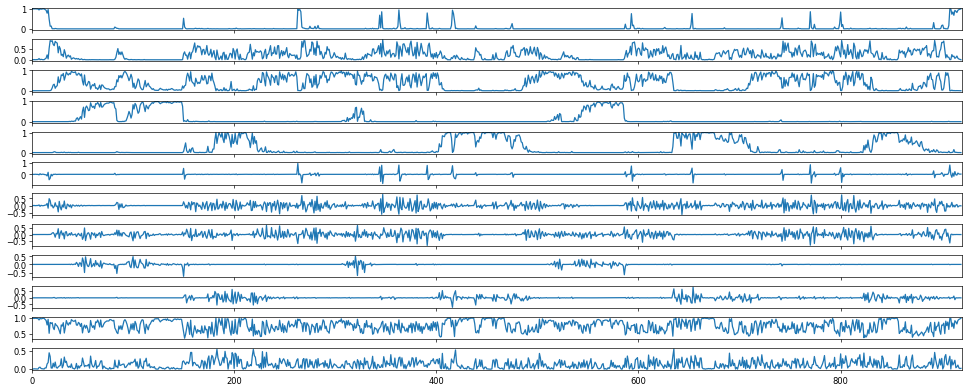

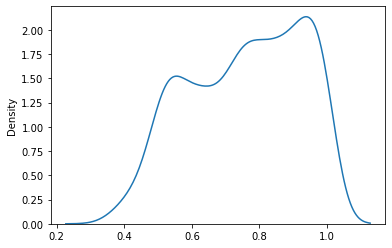

In [142]:
x = data['predicted']
N, M = x.shape
f, axes = plt.subplots(figsize=(20, 8), nrows=12, sharex=True, dpi=60, gridspec_kw={'hspace': 0.4})
for idx, ax in enumerate(axes.flat):
    if idx < M:
        ax.plot(range(N), x[:, idx])
    elif (idx >= M) & (idx < 2 * M):
        ax.plot(range(1, N), np.diff(x[:, idx % 5]))
#         ax.box(on=False)
#         ax.set_xlim(0, N)
#     elif idx == 10:
#         ax.plot(range(1, N), np.diff(np.linalg.norm(x, ord=2, axis=1)))
    elif idx == 10:
        ax.plot(range(0, N), x.max(axis=1))
    elif idx == 11:
        ax.plot(range(1, N), np.sqrt(np.diff(x.max(axis=1)) ** 2))
plt.xlim(0, N)
# plt.box(on=False)
import seaborn as sns
plt.figure()
sns.kdeplot(x.max(axis=1))


<AxesSubplot:ylabel='Density'>

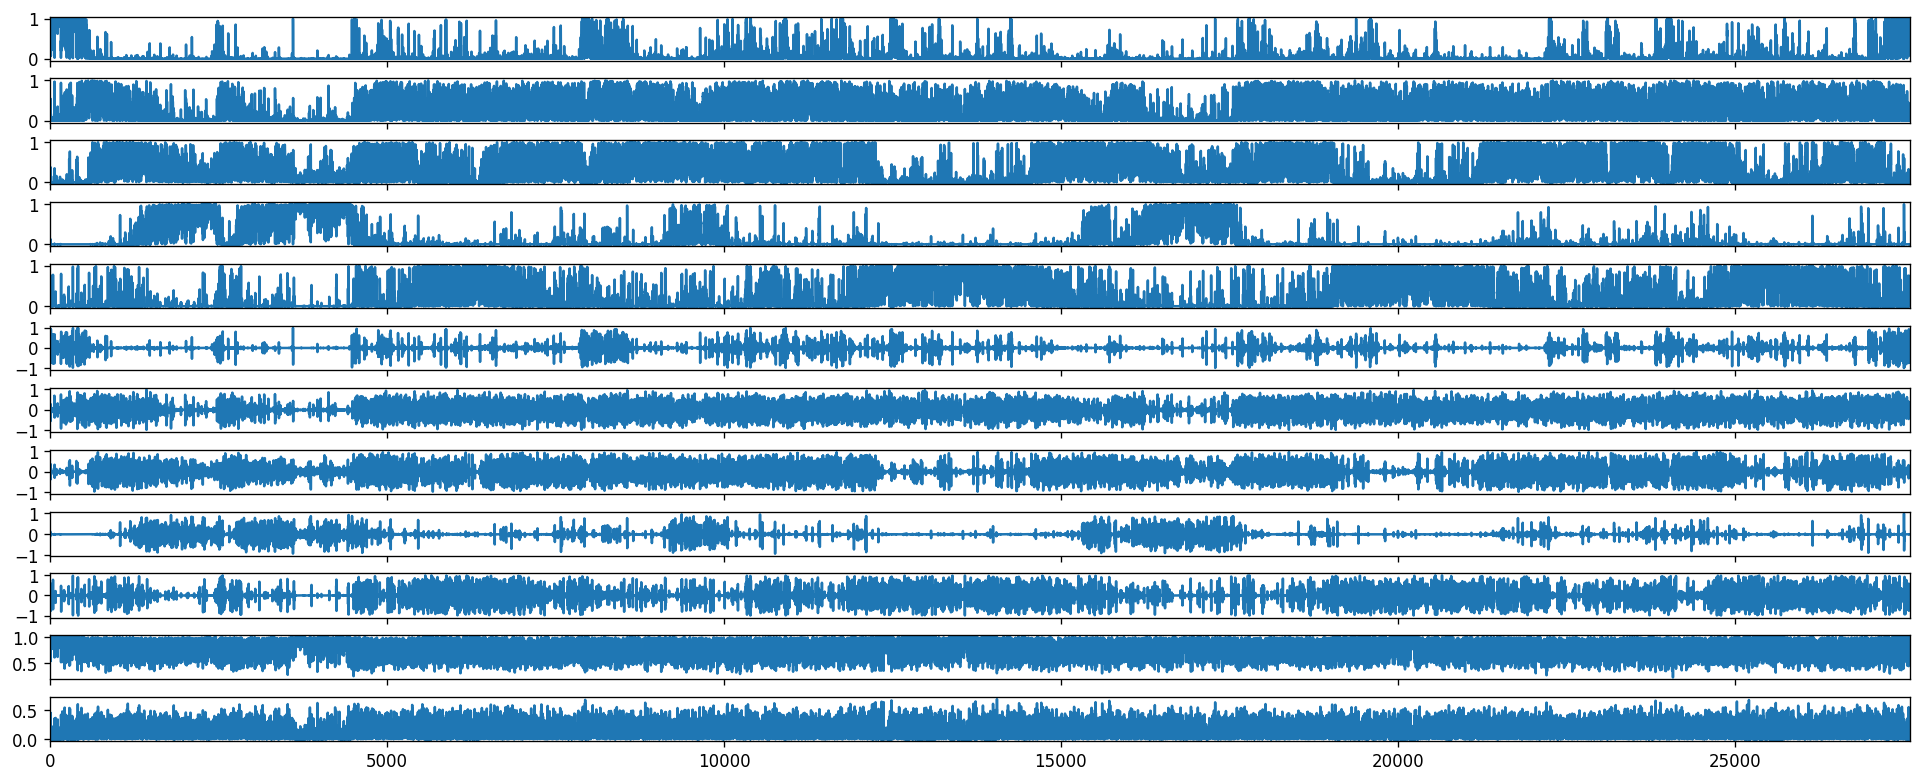

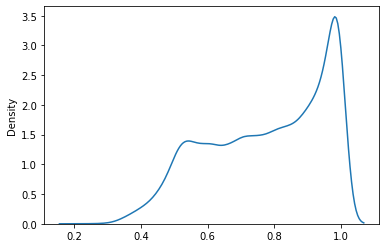

In [144]:
x = data['logits']
N, M = x.shape
f, axes = plt.subplots(figsize=(20, 8), nrows=12, sharex=True, dpi=120, gridspec_kw={'hspace': 0.4})
for idx, ax in enumerate(axes.flat):
    if idx < M:
        ax.plot(range(N), x[:, idx])
    elif (idx >= M) & (idx < 2 * M):
        ax.plot(range(1, N), np.diff(x[:, idx % 5]))
#         ax.box(on=False)
#         ax.set_xlim(0, N)
#     elif idx == 10:
#         ax.plot(range(1, N), np.diff(np.linalg.norm(x, ord=2, axis=1)))
    elif idx == 10:
        ax.plot(range(0, N), x.max(axis=1))
    elif idx == 11:
        ax.plot(range(1, N), np.sqrt(np.diff(x.max(axis=1)) ** 2))
plt.xlim(0, N)
import seaborn as sns
plt.figure()
sns.kdeplot(x.max(axis=1))
# plt.box(on=False)

## Covariance matrix

Text(0.5, 1.0, '1 s resolution')

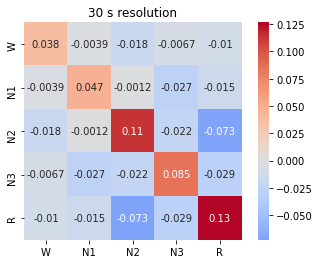

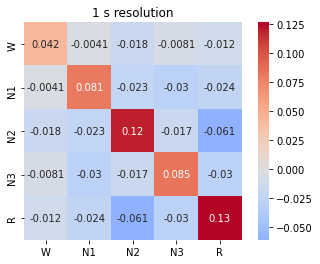

In [163]:
plt.figure()
sns.heatmap(np.cov(data['predicted'].T), center=0.0, annot=True, square=True, xticklabels=['W', 'N1', 'N2', 'N3', 'R'], yticklabels=['W', 'N1', 'N2', 'N3', 'R'], cmap='coolwarm')
plt.title('30 s resolution')

plt.figure()
sns.heatmap(np.cov(data['logits'].T), center=0.0, annot=True, square=True, xticklabels=['W', 'N1', 'N2', 'N3', 'R'], yticklabels=['W', 'N1', 'N2', 'N3', 'R'], cmap='coolwarm')
plt.title('1 s resolution')


## 1D Welch hypnogram

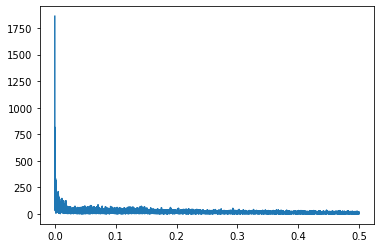

In [54]:
from scipy import fft
Fs = 1
T = 1/Fs
L = len(data['logits'][:, 0])
t = np.arange(L) * T
nfft = int(2 ** np.ceil(np.log2(len(data['logits'][:, 0]))))
X = fft.rfft(data['logits'][:, 0])
f = fft.rfftfreq(L, T)
plt.plot(f, np.abs(X))

## Multitaper spectrogram

{'frequency_range': [0, 0.5], 'time_bandwidth': 1.5, 'window_params': [60, 10], 'min_nfft': 64, 'detrend_opt': 'linear'}
Multitaper Spectrogram Properties: 
     Spectral Resolution: 0.05Hz
     Window Length: 60.0s
     Window Step: 10.0s
     Time Half-Bandwidth Product: 1.5
     Number of Tapers: 2
     Frequency Range: 0-0.5Hz
     Detrend: linear


 Multitaper compute time: 1.685701034963131 seconds


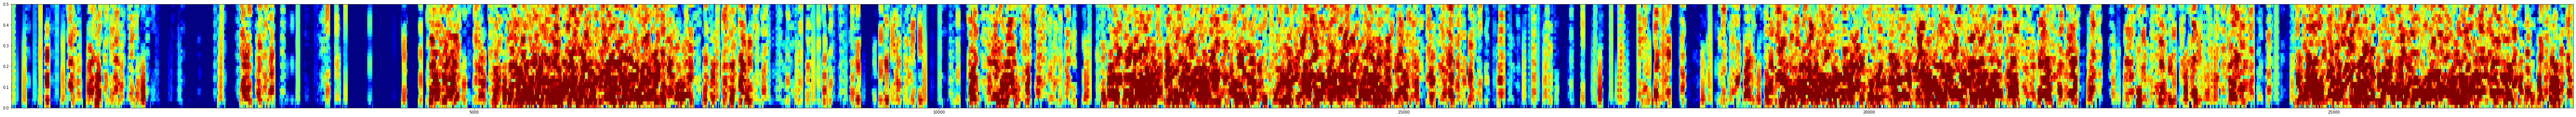

In [84]:
import librosa
from utils import multitaper_spectrogram
from utils.multitaper_spectrogram import nanpow2db
window_dur=60
window_step=10
delta_f=0.05
fs = 1
mts_params = dict(
    frequency_range=[0, 0.5],
    time_bandwidth=window_dur * delta_f / 2,
    window_params=[window_dur, window_step],
    min_nfft=int(2 ** np.ceil(np.log2(np.abs(window_dur * fs)))),
    detrend_opt='linear'
)
print(mts_params)
Zxx, spec_t, spec_f = multitaper_spectrogram(data['logits'][:, 4], fs, **mts_params, plot_on=False)

vmin, vmax = np.quantile(2 * nanpow2db(np.abs(Zxx)).T, [0.1, 0.9])
plt.figure(1, figsize=(120, 5))
plt.pcolormesh(
    np.array(spec_t).flatten(), np.array(spec_f).flatten(), 2 * nanpow2db(np.abs(Zxx)).T, cmap="jet", shading="auto", vmin=vmin, vmax=vmax
)
# mt_spectrogram.T.shape
# stimes.shape
# plt.figure(1, figsize=(30, 5))
# librosa.display.specshow(nanpow2db(mt_spectrogram), x_axis='time', y_axis='linear',
#                          x_coords=stimes.squeeze(), y_coords=sfreqs.squeeze(), shading='auto',
#                          cmap="jet")
# plt.colorbar(label='Power (dB)')
# plt.xlabel("Time (HH:MM:SS)")
# plt.ylabel("Frequency (Hz)")
# plt.show()